In [1]:
%matplotlib inline
from copy import deepcopy

# Module 12 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Modules 1 and 11, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

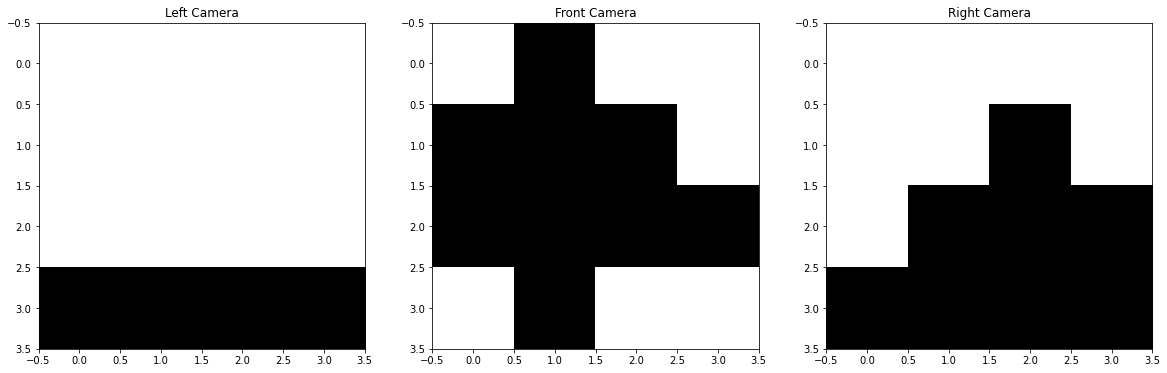

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

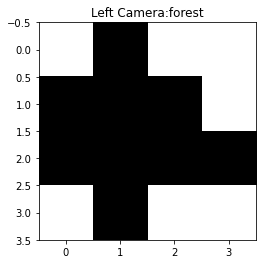

In [5]:
view_sensor_image( clean_data[ "forest"][0])

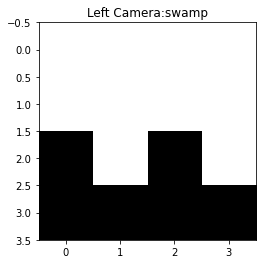

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

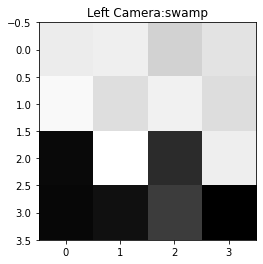

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.59). We always return the class with the higher probability.

If the data are labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `evaluate`

Ideally, we should be running 10 fold cross validation on this problem but...that might take a while so we're going to just go ahead with a simple evaluation. We're interested not only in the error rate but the overall "confusion" of the model.

The `evaluate` takes the results of `apply_model` when labeled=True and prints out the error rate and a confusion matrix.

---

Why `labeled=True` or `labeled=False`? While we only have labeled data right now, for model evaluation. In the future, you would need to use this function to do actual classification. In that case, `labeled=False`. Because in the long run, that's the default usage, we use `False` as the default.

---

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

---

Put your helper functions above here.

## Main Functions

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [9]:
def generate_data( data, n, key_label):
    labels = set(clean_data.keys())
    labels.remove(key_label)

    total_per_label = int(n/len(labels))
    data = []
    # create n "not label" and code as y=0
    for label in labels:
        for _ in range(total_per_label):
            datum = blur(random.choice(clean_data[label]))
            xs = datum[0:-1]
            data.append((xs, 0))
    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(clean_data[key_label]))
        xs = datum[0:-1]
        data.append((xs, 1))
    random.shuffle(data)
    return data

results = generate_data( clean_data, 10, "hills")
for result in results:
    print(result)

([0.06172513423234574, 0.23592363672926486, 0.12160553147573022, 0.19317886892462155, 0.967565087152456, 0.08659199305270643, 0.09642522795544894, 0.08294936014530511, 0.7355009516444457, 0.9111257323240597, 0.0863852236807589, 0.08214225600946364, 0.7372611227544699, 0.7167224163052397, 0.835843702000627, 0.10422959343031629], 1)
([0.0, 0.13952818632463204, 0.05606190841172322, 0.0012395693653946827, 0.10094381688852185, 0.1684713193243697, 0.008156788949058191, 0.053561564925015605, 0.13049027120979592, 0.007179056544905332, 0.21540345508809033, 0.08108834146051894, 0.8442220717768266, 0.9100409149532686, 0.9217186811398204, 0.7698358371403431], 0)
([0.02054211627031008, 0.2113859287429954, 0.11782099523340335, 0.0851950484583473, 0.07427047064984815, 0.8513864715038224, 0.09349589126142505, 0.16998507268173685, 0.8021529096748768, 0.8600568893404645, 0.7649732789843637, 0.14391594159766943, 0.8893308699285951, 0.7913063403507509, 1.0, 0.8209922963032474], 1)
([0.09403168469146614, 0

**calc_y_hat**<br>
The `calc_y_hat` is a helper functionf for `learn_model`. It calculates the $\hat{y}$t given the data and the thetas. It uses the below function to calculate the $\hat{y}$.

$$ \hat{y} = \frac{1}{1+e^{-\theta_0}} $$

Parameters:
* **data**: a `List` of `List`s contaning the data we need to calculate $\hat{y}$
* **theta** is the `list` of float values we needed to calculate  $\hat{y}$


The function returns `List` of calculated  $\hat{y}$ values</br>
For example if data and theta are as shown below.
```
data = [[1.8, 0], [2.7, 1.0]]
theta = [0.8, 1.1]
```
retuns:<br>
`[0.94158544, 0.97746736]`

In [10]:
def calc_y_hat(data, theta):
    m_data = np.hstack((np.ones((len(data),1)), data))  # set Xo = 1
    z = theta.dot(m_data[:,:-1].T)
    y_hat = 1/(1+np.exp(-z)) # reverse theta and pass in everyhthing but last y column
    y_hat = np.ravel(y_hat)
    return y_hat

**calc_error**<br>
The `calc_error` is a helper functionf for `learn_model`. It calculates the error using the loss function given the data and the thetas. It uses the below function to calculate the $error$.

$$ J(\theta) = - \frac{1}{n}\sum_i y_i log(\hat{y_i}) + (1 - y_i)log(1 - \hat{y_i} ) $$

Parameters:
* **data**: a `List` of `List`s contaning the float values}
* **theta** is the `list` of float values


The function returns calculated `float` value.</br>
For example if data and theta are as shown below.
```
data = [[1.8, 0], [2.7, 1.0]]
theta = [0.8, 1.1]
```
retuns:<br>
`0.46871918071283825`

In [11]:
def calc_error(data, theta):
    y_hat = calc_y_hat(data,theta)
    ones = np.ones(len(data))
    loss = -np.mean(data[:,-1] * np.log(y_hat) + (ones - data[:,-1]) * np.log(ones - y_hat))
    return loss

**derivitive**<br>
The `derivitive` is a helper functionf for `learn_model`. It calculates the derivitive to update the theta values while learning the model. It uses the below function to calculat the derivitive

$$ \frac{\partial J}{\partial \theta_j} = \frac{1}{n}\sum_i(\hat{y_i} - y_i)x_{ij} $$

Parameters:
* **data**: a `List` of `List`s contaning the float values
* **theta** is the `list` of float values
* **t_indx** keeps track of which theta we are currently calculating the derivitive of. theta_0 would make t_index=0.


The function returns calculated `float` value.</br>
For example if data, t_indx and theta are as shown below.
```
data = [[1.8, 0], [2.7, 1.0]]
theta = [0.8, 1.1]
t_indx = 0
```
retuns:<br>
`0.8429655191367142`

In [12]:
def derivitive(data, theta, t_indx):
    y_hat = calc_y_hat(data, theta)
    ones = np.ones((len(data),1))
    m_data = np.hstack((ones, data))  # set Xo = 1
    der = (y_hat - data[:, -1]) * m_data[:, t_indx]
    der = np.mean(der)
    return der

**learn_model**<br>
The `learn_model` function implements the logistics regression algorithm. It calculates thetas that will reduce the error rate. The algorithm adapts the alpha value as required.


Parameters:
* **orig_data**: a `List` of `List`s contaning the float values
* **verbose** is `boolean` variable that indicates if want to print error_rates or not. it is set to `False` by default.
* **epsilon** is the value used to decide when to stop running the algorithm. It is set to `1e-07` by default.
* **alpha** is the learning rate for the logistic regression algorithm. It is set to `0.1` by default.


The function returns a `List` of theta values that give the smallest error.</br>

In [13]:
def learn_model( orig_data, verbose=False, epsilon = 1e-06, alpha = 0.1):                              
    labels = np.array(list(zip(*orig_data))[1]).reshape((len(orig_data),1))   # seperate label
    data = np.hstack((list(zip(*orig_data))[0], labels))                      # combine data and label as matrix
    theta = np.random.uniform(-1, 1, len(data[0]))                            # genrate thetas (-1, 1)
    p_error, t = 0.0, 0
    c_error = calc_error(data, theta)
    while abs(c_error-p_error) > epsilon:
        # print("Error", c_error) if verbose and t %1000 ==0 else None
        if t %1000 == 0 and verbose == True:
            print("Error for iteration " + str(t) + "=", c_error)  
        new_theta = np.zeros(len(theta))
        for t_indx in range(len(theta)):
            new_theta[t_indx] = theta[t_indx] - alpha * derivitive(data, theta, t_indx) 
        theta = new_theta
        p_error = c_error
        c_error = calc_error(data, theta)
        alpha = alpha/10 if c_error > p_error else alpha   # update alpha is current erro > previous error
        t += 1
    return theta

**predict**<br>
The `predict` is a helper function for `apply_model`. Given the trained theta values and the test point it calculates the probability of datapoint.


Parameters:
* **model**: a `List` of float values.
* **test** is the testpoint we want to predict a probability for.


The function returns a `probability` for the given testpoint.</br>

In [14]:
def predict(model, test):
    test = np.array(test).reshape((len(test), 1))
    test = np.vstack((np.ones((1,1)), test))
    z = model.dot(test)
    prob = 1/(1+np.exp(-z))
    return prob[0]

**apply_model**<br>
The`apply_model` function calculate the probility for each of the testpoint in the test_data. If the test points are labeled then it created a list of (actual_label, predicted_label). If the given testpoint is unlabeled then it creates a list tuples of format (predicted label, predicted probability).


Parameters:
* **model**: a `List` of float values.
* **test_data** is `List` of testpoints we want to predict a probability for.
* **labeled** indicates whether the testpoints are labeled or not.


The function returns a ` List of probabilities (tuples)` for the given test_data.</br>

In [15]:
def apply_model( model, test_data, labeled=False):
    if labeled:   # we have labeled data
        pred = [(test[1], round(predict(model, test[0]), 0)) for test in test_data]
    else:                             # we do not have labeled data
        pred = []
        for test in test_data:
            test_pred = predict(model, test)
            pred += [(round(test_pred, 0), test_pred)]
    return pred

**print_confusion_matrix**<br>
The`print_confusion_matrix` function prints the confusion matrix given the dictionary contaning TP, TN, FP, FN. It prins the confusion matrix.


Parameters:
* **dct**: a `Dict` containing number of TP, TN, FP, FN.


The function prints the confusion matrix in the below format.
```
Confusion Matrix
         _______________________
        |        Predicted     |
________|_______ 1 __|___ 0 ___|
    A   |   |        |         |
    c   | 1 |    TP  |    FN   |
    t   |___|________|_________|
    u   |   |        |         |
    a   | 0 |   FP   |   TN    |
    l   |___|________|_________|
```

In [16]:
def print_confusion_matrix(dct):
    print("Confusion Matrix")
    print("         "+"_"*23)
    print("        "+"|        Predicted     |")
    print("________"+"|_______ {} __|___ {} ___|".format(1,0))
    print("    A   |   |        |         |")
    print("    c   | {} |    {}  |    {}    |".format(1, dct[(1,1)], dct[(1,0)]))
    print("    t   |___|________|_________|")
    print("    u   |   |        |         |")
    print("    a   | {} |    {}   |   {}    |".format(0, dct[(0,1)], dct[(0,0)]))
    print("    l   |___|________|_________|")

In [17]:
def evaluate(results):
    dct = {(0,0):0, (0,1):0, (1,0):0, (1,1):0}
    for tp in results:
        dct[tp] += 1
    error_rate = (dct[(0,1)] + dct[(1,0)]) / len(results)
    print(f"Error rate: {round(error_rate*100, 3)}%")
   
    print_confusion_matrix(dct)

## Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Set labeled=True. Print out the first 10 results, one per line.

In [18]:
train_data = generate_data(clean_data, 100, "hills")

In [19]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [20]:
model = learn_model( train_data, True)

Error for iteration 0= 1.0918476399402506
Error for iteration 1000= 0.36689559151443146
Error for iteration 2000= 0.25742855653286983
Error for iteration 3000= 0.20524920531499788
Error for iteration 4000= 0.1736995076782965
Error for iteration 5000= 0.15216778450813553
Error for iteration 6000= 0.13633982115763046
Error for iteration 7000= 0.12410480062638582
Error for iteration 8000= 0.11429834423176569
Error for iteration 9000= 0.10622108183575943
Error for iteration 10000= 0.09942524100192268
Error for iteration 11000= 0.09360950407433695
Error for iteration 12000= 0.0885628539790736
Error for iteration 13000= 0.08413260348105288
Error for iteration 14000= 0.08020522042830855
Error for iteration 15000= 0.07669431907115075
Error for iteration 16000= 0.07353285933841895
Error for iteration 17000= 0.0706679184414895
Error for iteration 18000= 0.068057090269914
Error for iteration 19000= 0.06566594630684587
Error for iteration 20000= 0.0634662072942173
Error for iteration 21000= 0.0614

Apply the model to the test data:

In [21]:
results = apply_model( model, test_data, labeled=True)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [22]:
evaluate(results)

Error rate: 0.503%
Confusion Matrix
         _______________________
        |        Predicted     |
________|_______ 1 __|___ 0 ___|
    A   |   |        |         |
    c   | 1 |    99  |    1    |
    t   |___|________|_________|
    u   |   |        |         |
    a   | 0 |    0   |   99    |
    l   |___|________|_________|


## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.

In [ ]:
# def learn_model( data, hidden_nodes, iterations= 10000, verbose=False, alpha = 0.01):
#     theta_in = np.random.rand(hidden_nodes, data.shape[1])
#     theta_out = np.random.rand(4, hidden_nodes+1)
#     # theta_in = np.array([[0.01, 0.26, -.42],[-0.05, 0.78, 0.19],[0.42, -.23, .37]])
#     # theta_out = np.array([[0.2, 0.61, 0.12, -0.9],[0.3, 0.28, -0.34, 0.10]])
#     count = 0
#     model_list = []
    
#     while count != iterations:
#         print(count) if verbose and count%1000== 0 else None
#         hidden_l = calc_y_hat(data[:,:-1], theta_in).T     # hidden layer
#         out_l = calc_y_hat(hidden_l, theta_out).T # output layer
#         delta_o = np.multiply(np.multiply(out_l,(1-out_l)), np.array(data[:,-1].tolist()) - out_l)
#         hidden_l = np.hstack((np.ones((len(hidden_l),1)), hidden_l))
#         delta_h = np.multiply(np.multiply(hidden_l, (1-hidden_l)), np.dot(delta_o, theta_out))[:,1:]   # drop the leading 1 we added for bias term
#         theta_out = update_theta(theta_out, alpha, hidden_l, delta_o)
#         lead_1_data = np.hstack((np.ones((data.shape[0],1)), data[:,:-1]))   # add a leading 1 and remove label column
#         theta_in  = update_theta(theta_in, alpha, lead_1_data, delta_h)
#         # print(theta_in,"\n",  theta_out)
#         # print("\n")
#         if count%100 ==0:
#             model_list += [(theta_in, theta_out, count)]
#         count += 1
#     model = (theta_in, theta_out)
#     model_list += [(theta_in, theta_out, count)]
#     return model

# # inpt = np.array([[0.52, -0.97, [1,0]]])
# # theta_in = np.array([[0.01, 0.26, -.42],[-0.05, 0.78, 0.19],[0.42, -.23, .37]])
# # theta_out = np.array([[0.2, 0.61, 0.12, -0.9],[0.3, 0.28, -0.34, 0.10]])
# # learn_model(inpt, 3, 1)
# # x = learn_model(results[:10], 8, 2)